# GenAI Automated Doc Extraction and Generation

## Prereqs

---
### Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [ ]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Main Code

### Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [2]:
REGION = 'us-central1'

# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID

packages:

In [23]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

import vertexai.vision_models # Imagen Models
import vertexai.preview.vision_models
import vertexai.generative_models # for Gemini Models
import vertexai.language_models # PaLM and Codey Models
from vertexai.generative_models import GenerationConfig, GenerativeModel, Part

import json
import io
import base64
import asyncio
import requests
import IPython
import datetime, time
import pandas as pd

In [4]:
aiplatform.__version__

'1.67.1'

clients:

In [5]:
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

bucket = gcs.lookup_bucket(BUCKET)

### Initiate model(s)


In [292]:
# Gemini Models
gemini15_multimodal = vertexai.generative_models.GenerativeModel("gemini-1.5-pro-002")
gemini_flash = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-002")

### Document Extractor

In [246]:
PDF_MIME_TYPE = "application/pdf"

def print_multimodal_prompt(contents: list) -> None:
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if not isinstance(content, Part):
            print(content)
        elif content.inline_data:
            display_pdf(content.inline_data.data)
        elif content.file_data:
            gcs_url = (
                "https://storage.googleapis.com/"
                + content.file_data.file_uri.replace("gs://", "").replace(" ", "%20")
            )
            print(f"PDF URL: {gcs_url}")

# Send Google Cloud Storage Document to Vertex AI
def process_document(
    prompt: str,
    file_uri: str = None,
    mime_type: str = PDF_MIME_TYPE,
    model = gemini15_multimodal,
    generation_config: GenerationConfig | None = None,
    print_prompt: bool = False,
    print_raw_response: bool = False
) -> str:
    # Load file directly from Google Cloud Storage
    if file_uri != None:
        file_part = Part.from_uri(
            uri=file_uri,
            mime_type=mime_type,
        )

    # Load contents
    contents = [file_part, prompt]

    # Send to Gemini
    response = model.generate_content(contents, generation_config=generation_config)

    return response.text

In [320]:
generation_config_extract = GenerationConfig(
    temperature=0.0, response_mime_type="application/json"
)

generation_config_validate = GenerationConfig(
    temperature=0.5
)

In [321]:
doc_entity_extraction_prompt = """You are a document entity extraction specialist. Given a document, your task is to identify and export all of the submittals included in the document.  
Include the NAME of the submittal.
Include the DESCRIPTION of the submittal.
Include OTHER INFORMATION related to the submittal.
Include what PAGE the submittal is on.

If you are not sure if the item is a submittal, include it anyways.
The JSON schema must be followed during the extraction.
The values must only include text found in the document.
"""

In [322]:
response_text = process_document(
    doc_entity_extraction_prompt,
    "gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf",
    generation_config=generation_config_extract
)

In [323]:
json_object = json.loads(response_text)
#print(json_object)
json_object

{'submittals': [{'name': 'Shop Drawings',
   'description': 'Includes technical data and drawings specially prepared for this Project, including fabrication and installation drawings, diagrams, actual performance curves, data sheets, schedules, templates, patterns, reports, instructions, design mix formulas, measurements, and similar information not in standard printed form.',
   'other_information': 'Standard information prepared without specific reference to the Project is not considered a Shop Drawing.',
   'page': '1, 2'},
  {'name': 'Product Data',
   'description': "Includes standard printed information on manufactured products, and systems that has not been specially prepared for this Project, including manufacturer's product specifications and installation instructions, catalog cuts, standard wiring diagrams, printed performance curves, mill reports, and standard color charts.",
   'other_information': None,
   'page': '2'},
  {'name': 'Samples',
   'description': 'Includes bot

In [325]:
temp_df = pd.json_normalize(json_object['submittals'])
temp_df['submittal'] = ''
temp_df

,name,description,other_information,page,submittal
0,Shop Drawings,Includes technical data and drawings specially...,Standard information prepared without specific...,"1, 2",
1,Product Data,Includes standard printed information on manuf...,None,2,
2,Samples,Includes both fabricated and manufactured phys...,Mock-ups are special forms of samples which ar...,2,
3,Working Drawings,"When used in the Contract Documents, the term ...",Copies of working drawings shall be submitted ...,2,
4,Miscellaneous Submittals,Work-related submittals that do not fit in the...,None,"2, 3",
5,"Substitution or ""Or Equal""",Includes material or equipment CONTRACTOR requ...,None,"1, 5",
6,preliminary schedule of shop drawings and samp...,None,"in duplicate, and in accordance with the Gener...",3,
7,each submittal,None,Prepare and transmit each submittal to ENGINEE...,3,
8,Operation and Maintenance Manuals,None,Submit Operation and Maintenance Manuals in ac...,9,
9,Closeout submittals,"closeout information, materials, tools, and si...",Refer to Specification Section 01720 for speci...,9,


### Determine if submittal

In [326]:
for index, row in temp_df.iterrows():
    main = row['description']
    other = row['other_information']
    
    prompt = f"""Consider the 2 descriptions below.  
    Determine which one is a submittal.  
    A submittal includes details for submitting documents or information, and will include words like submit, survey, prepare, collect, or similar. 
    Return only the exact text of the description that was determined to be a submittal.
    The submittal cannot be None.

    {main}

    {other}
    """
    
    response = gemini15_multimodal.generate_content(prompt, generation_config=generation_config_validate)
    
    temp_df.at[index, 'submittal'] = response.text
    
submittal_df = temp_df[temp_df['submittal'] != "None\n"]
submittal_df

,name,description,other_information,page,submittal
0,Shop Drawings,Includes technical data and drawings specially...,Standard information prepared without specific...,"1, 2",Includes technical data and drawings specially...
1,Product Data,Includes standard printed information on manuf...,None,2,Includes standard printed information on manuf...
2,Samples,Includes both fabricated and manufactured phys...,Mock-ups are special forms of samples which ar...,2,Includes both fabricated and manufactured phys...
3,Working Drawings,"When used in the Contract Documents, the term ...",Copies of working drawings shall be submitted ...,2,Copies of working drawings shall be submitted ...
4,Miscellaneous Submittals,Work-related submittals that do not fit in the...,None,"2, 3",Work-related submittals that do not fit in the...
5,"Substitution or ""Or Equal""",Includes material or equipment CONTRACTOR requ...,None,"1, 5",Includes material or equipment CONTRACTOR requ...
7,each submittal,None,Prepare and transmit each submittal to ENGINEE...,3,Prepare and transmit each submittal to ENGINEE...
8,Operation and Maintenance Manuals,None,Submit Operation and Maintenance Manuals in ac...,9,Submit Operation and Maintenance Manuals in ac...
9,Closeout submittals,"closeout information, materials, tools, and si...",Refer to Specification Section 01720 for speci...,9,Refer to Specification Section 01720 for speci...
10,Shop Drawings and Operation and Maintenance Ma...,None,submitted for each item will be reviewed no mo...,11,submitted for each item will be reviewed no mo...


In [330]:
for i in submittal_df['submittal']:
    print(i)

Includes technical data and drawings specially prepared for this Project, including fabrication and installation drawings, diagrams, actual performance curves, data sheets, schedules, templates, patterns, reports, instructions, design mix formulas, measurements, and similar information not in standard printed form.

Includes standard printed information on manufactured products, and systems that has not been specially prepared for this Project, including manufacturer's product specifications and installation instructions, catalog cuts, standard wiring diagrams, printed performance curves, mill reports, and standard color charts.

Includes both fabricated and manufactured physical examples of materials, products, and units of work, partial cuts of manufactured or fabricated work, swatches showing color, texture, and pattern, and units of work to be used for independent inspection and testing.

Copies of working drawings shall be submitted to the ENGINEER at least fourteen (14) calendar 

## RAG for Submittal Metadata

#### Setup

In [74]:
# add rag flow that loops through submittals and creates a higher accuracy set of data

In [26]:
REGION = 'us-central1'
EXPERIMENT = 'submittal-retriever'
SERIES = 'genai-demos'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2]

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf']

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

In [101]:
from google.cloud import documentai
from google.api_core import retry

import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

In [37]:
textembed_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko')

In [38]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/633472233130/locations/us/processors/dbdbd2e45a1c5f6e


#### Get previous runs or prepare new documents

In [39]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    # do a check for prior run and present message if found letting user know the prior result exists but not being used
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')

elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Importing previous run from GCS')

    # load files_pages: the file+page level information including docai responses in `parsing`
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
    files_pages_chunks = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True

elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Importing previous run from BigQuery')

    # load files_pages: the file+page level information including docai responses in `parsing`
    files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # convert json string to dictionary:
    for page in files_pages:
        page['parsing'] = json.loads(page['parsing'])
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    files_pages_chunks = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks`').to_dataframe().to_dict('records')
    #convert json string to dictionary:
    for chunk in files_pages_chunks:
        chunk['metadata'] = json.loads(chunk['metadata'])
    # sort chunk by file, page, chunk number:
    files_pages_chunks = sorted(files_pages_chunks, key = lambda x: (x['metadata']['file_index'], x['metadata']['page_index'], x['metadata']['chunk']))

    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
        
else:
    print('No previous run available to import')
    PRIOR_PARSE = False

No previous run available to import


In [40]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    document_locations = []
    for source_document in source_documents:
        if source_document.startswith('http'):
            document_locations.append('URL')
            print(f'Use requests to get online document: {source_document}')
        elif source_document.startswith('gs'):
            document_locations.append('GCS')
            print(f'Use GCS to get document in GCS: {source_document}')
        else:
            document_locations.append('UNKNOWN')
            print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use GCS to get document in GCS: gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf


Import the PDF to memory as bytes:

In [41]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    imported_documents = []
    for s, source_document in enumerate(source_documents):
        if document_locations[s] == 'URL':
            imported_documents.append(requests.get(source_document).content)
        elif document_locations[s] == 'GCS':
            blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
            imported_documents.append(blob.download_as_bytes())
        elif document_locations[s] == 'UNKNOWN':
            imported_documents.append(None)
    type(imported_documents[0])       

Convert from bytes to PDF:

In [42]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    converted_documents = []
    for imported_document in imported_documents:
        if imported_document:
            converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
        else:
            converted_documents.append(None)
        type(converted_documents[0])    

Review number of pages per PDF:

In [43]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    for f, file in enumerate(converted_documents):
        if file:
            print(f"{source_documents[f]} has {len(file.pages)} pages")

gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf has 12 pages


Split PDF(s) to list of individual pages for each file:

List of dictionaries with keys: file_index, page_index, raw_file_page

In [44]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    # list of tuples (file index, page number, page content)
    files_pages = []
    for c, converted_document in enumerate(converted_documents):
        if converted_document:
            for page_num, page in enumerate(converted_document.pages, 1):
                writer = PyPDF2.PdfWriter()
                writer.add_page(page)
                with io.BytesIO() as bytes_stream:
                    files_pages.append(
                        dict(file_index = c, page_index = page_num, raw_file_page = writer.write(bytes_stream)[1].getbuffer().tobytes())
                    )
len(files_pages)

12

In [45]:
async def docai_runner(files_pages, limit_concur_requests = 120):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await docai_async_client.process_document(
                        request = dict(
                            raw_document = documentai.RawDocument(
                                content = files_pages[p]['raw_file_page'],
                                mime_type = 'application/pdf'
                            ),
                            name = parser.name
                        )
                    )
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = documentai.Document.to_dict(result.document)
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    # add parsing to input list of dictionaries for all the pages
    for c, content in enumerate(files_pages):
        content['parsing'] = results[c]
    
    return

In [46]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    await docai_runner(files_pages)
    # remove the raw file page
    for page in files_pages: del page['raw_file_page']

No Prior Results, Parsing with Document AI


In [47]:
len(files_pages)

12

In [48]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [49]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions'])

For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [50]:
async def embedding_pages(files_pages, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    if files_pages[p]['parsing']['text']:
                        result = await textembed_model.get_embeddings_async([files_pages[p]['parsing']['text']])
                    else:
                        obj = lambda: None
                        obj.values = [None]
                        result = [obj]
                    
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    for c, content in enumerate(files_pages):
        content['parsing']['embedding'] = results[c]
    
    return

In [51]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    await embedding_pages(files_pages)
    for c, content in enumerate(files_pages):
        document_image = PIL.Image.open(
            io.BytesIO(
                base64.decodebytes(content['parsing']['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        content['parsing']['path'] = source_documents[content['file_index']][:(-1*len(source_documents[content['file_index']].split('/')[-1]))]
        content['parsing']['file'] = source_documents[content['file_index']].split('/')[-1]
        content['parsing']['page'] = content['page_index']
        content['parsing']['vme_id'] = f"{content['file_index']}_{content['page_index']}"
        content['parsing']['dimensions'] = list(document_image.size)
        if not content['parsing']['text']:
            content['parsing']['embedding'] = []

No Prior Results, Using Document AI Parsing


In [52]:
len(files_pages)

12

In [53]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [54]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

### Parse Chunks From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [55]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_chunks = []
    
    for content in files_pages:
        page = content['parsing']
        chunk_id = 0
        
        # parse tables from page:
        tables = []
        for t, table in enumerate(page['pages'][0]['tables']):

            table_txt = ''
            if 'text_anchor' in table['layout'].keys():
                for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                    if t == 0 and s == 0: start = 0
                    else: start = int(segment['start_index'])
                    end = int(segment['end_index'])
                    table_txt += page['text'][start:end+t]

            vertices = []
            normalized_vertices = []
            for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

            if table_txt != '':
                files_pages_chunks.append(
                    dict(
                        text = table_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            table = t + 1,
                            chunk = chunk_id + 1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1       
        
        # parse paragraphs from page - not in tables or overlapping tables
        for g, paragraph in enumerate(page['pages'][0]['paragraphs']):

            # get the paragraph text
            paragraph_txt = ''
            for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                if p == 0 and s == 0: start = 0
                else: start = int(segment['start_index'])
                end = int(segment['end_index'])
                paragraph_txt += page['text'][start:end+1]

            # if paragraph not empty, get/calc the vertices
            if paragraph_txt != '':
                use_paragraph = True
                vertices = []
                normalized_vertices = []
                for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                    normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                    vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            else:
                use_paragraph = False

            # only use paragraphs that are not within/overlapping table boundaries
            if use_paragraph:
                for t_shape in tables:
                    p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                    if p_shape.intersects(t_shape):
                        use_paragraph = False

            # save the paragraph as an element
            if use_paragraph:
                files_pages_chunks.append(
                    dict(
                        text = paragraph_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            paragraph = g + 1,
                            chunk = chunk_id +1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1        

In [56]:
len(files_pages_chunks)

206

In [57]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata'])

In [58]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'table', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Get Embeddings


The `textembedding-gecko` model has quota of 1500 request per minute:
- [Quotas by region and model](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#quotas_by_region_and_model)

In [59]:
async def embedding_runner(files_pages_chunks, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages_chunks)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await textembed_model.get_embeddings_async([files_pages_chunks[p]['text']])
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages_chunks))]
    responses = await asyncio.gather(*tasks)
    
    # add embeddings to input list of dictionaries for all the chunks
    for c, content in enumerate(files_pages_chunks):
        content['embedding'] = results[c]
    
    await asyncio.sleep(60)
    
    return

In [60]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    await embedding_runner(files_pages_chunks)

In [61]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [62]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'table', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

In [63]:
files_pages_chunks[0]['embedding'][0:5]

[-0.002199284266680479,
 -0.043500252068042755,
 -0.018851717934012413,
 -0.0061989170499145985,
 0.03954693302512169]

---
## Save Files For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [64]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [65]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [66]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
        blob.upload_from_string('\n'.join([json.dumps(chunk) for chunk in files_pages_chunks]), content_type = 'application/json')

    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = BQ_REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)  

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("file_index", "INT64"),
                    bigquery.SchemaField("page_index", "INT64"),
                    bigquery.SchemaField("parsing", "JSON")
                ]
            ) 
        )
        load_job.result()
        
        # save files_pages_chunks
        load_job = bq.load_table_from_json(
            json_rows = files_pages_chunks,
            destination = ds.table(BQ_TABLE + '_files_pages_chunks'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("text", "STRING"),
                    bigquery.SchemaField("metadata", "JSON"),
                    bigquery.SchemaField("embedding", "FLOAT", "REPEATED")
                ]
            ) 
        )
        load_job.result()

Writing contents of results and documents to GCS for future use.
Writing contents of results and documents to BigQuery for future use.


---
### Embeddings Search: AKA Vector Search

There are many ways to do vector search. In production there are considerations, including:
- How many indexes?
- What is the size of indexes?
- What is the lifespan and frequency of indexes?
- How frequently will indexes get updates (append, update, delete)?
- How quickly do updates need to surface in searches?
- What is the next step after a search?  Does the coorespondinng text need to be retrieved separately?

#### Get Embedding for Question

In [81]:
question = "Is there a submittal related to Shop Drawings?"

In [82]:
print(question)

Is there a submittal related to Shop Drawings?


In [83]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
query_embed.shape

(768,)

#### Create Local Embedding DB - With Numpy!

In [84]:
embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])
embed_db.shape

(206, 768)

#### Get Matches - With Numpy!

##### Dot Product

- measures alignment between two vectors
- large positive implies similar directions
- large negative implies opposite directions
- near zero implies orthoganal
- larger is more similar
- best for:
    - matching and retrieval


In [85]:
similarity = np.dot(query_embed, embed_db.T)
similarity.shape

(206,)

In [86]:
# larger is more similar
matches = np.argsort(similarity)[::-1][:5].tolist()
matches = [(match, similarity[match]) for match in matches]
matches

[(108, 0.8385441031844267),
 (34, 0.8145080117935397),
 (127, 0.8033323788615065),
 (84, 0.8028868474601334),
 (8, 0.7970953384695907)]

In [87]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Submittals:
a
Miscellaneous Submittals:
a
Miscellaneous Submittals:
1
Shop Drawings:
1
Shop Drawings:
a


##### Cosine Similarity

- measures angle between two vectors
- represents the cosine of the angles resulting in values -1 to 1
- larger is more similar
- best for:
    - grouping for topics: different magnitudes can still group together
    - collaborative filtering for recommendation systems


In [88]:
cosine_similarity = similarity / (np.linalg.norm(query_embed) * np.linalg.norm(embed_db, axis = 1).T)
cosine_similarity.shape

(206,)

In [89]:
# larger is more similar
matches = np.argsort(cosine_similarity)[::-1][:5].tolist()
matches = [(match, cosine_similarity[match]) for match in matches]
matches

[(108, 0.8385460212430578),
 (34, 0.8145099120059557),
 (127, 0.8033342170808793),
 (84, 0.8028886409811823),
 (8, 0.7970970618987006)]

In [90]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Submittals:
a
Miscellaneous Submittals:
a
Miscellaneous Submittals:
1
Shop Drawings:
1
Shop Drawings:
a


##### Euclidean Distance

- straight line distance between two vector points
- smaller is more similar
- note that smaller magnitude vectors with large angles may be deemed more similar than larger magnitude vectors with small angles
- best for:
    - clustering points in vector space
    - anomaly detection

In [91]:
euclidean_similarity = np.linalg.norm(embed_db - query_embed, axis = 1)
euclidean_similarity.shape

(206,)

In [92]:
# smaller is more similar
matches = np.argsort(euclidean_similarity)[:5].tolist()
matches = [(match, euclidean_similarity[match]) for match in matches]
matches

[(108, 0.5682492577261918),
 (34, 0.6090807093556653),
 (127, 0.6271607974054629),
 (84, 0.6278708763822247),
 (8, 0.6370282558856527)]

In [93]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Submittals:
a
Miscellaneous Submittals:
a
Miscellaneous Submittals:
1
Shop Drawings:
1
Shop Drawings:
a


#### Search Function: Pages

Using dot product, create an embedding database and accompanying search function.

In [94]:
pages_embed_db = np.array([page['parsing']['embedding'] if page['parsing']['embedding'] else [0]*768 for page in files_pages])

In [95]:
def page_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, pages_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [96]:
page_match(question)

[(0, 0.8130597655259885),
 (4, 0.8076347499974135),
 (10, 0.7750101798639458),
 (1, 0.7701003782305597)]

#### Search Function: Chunks

Using dot product, create an embedding database and accompanying search function.

In [97]:
chunks_embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])

In [98]:
def chunk_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [99]:
chunk_match(question)

[(108, 0.8385441031844267),
 (34, 0.8145080117935397),
 (127, 0.8033323788615065),
 (84, 0.8028868474601334)]

---
### Visualize Relationships Between Chunks

The embeddings are incredibly high dimensional - 768!  To reduce this to a lower dimension, like 2 for plotting, the method [`t-SNE`](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) will be used.  This method models each embedding with a lower 2-dimensional point in a way that similar embeddings are modeled by nearby poiints and dissimilar embeddings by farther points.

#### Visualizing Chunks

In [102]:
tsne = TSNE(random_state=0, n_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(chunks_embed_db)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [103]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-37.77910804748535, 34.34842872619629, -19.17257914543152, 14.081841802597046)

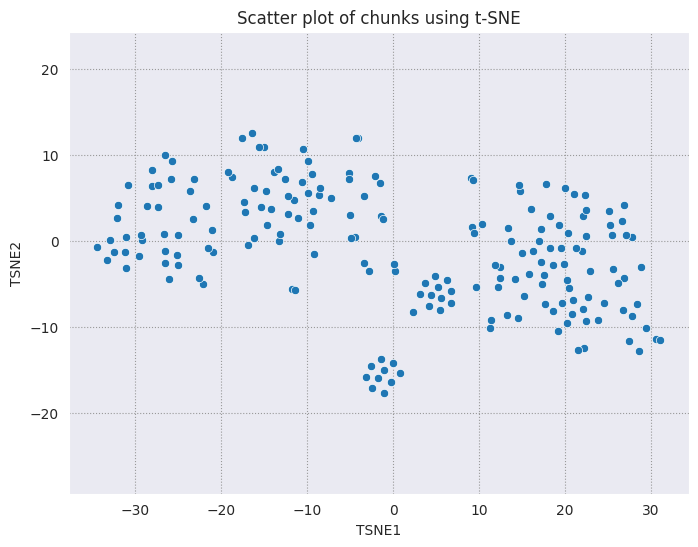

In [104]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2')
plt.title("Scatter plot of chunks using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

#### Visualizing Chunks - Color Codeded By Similarity To Prompt

In [105]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
similarity = np.dot(query_embed, chunks_embed_db.T)
df_tsne['similarity'] = similarity.tolist()

(-37.77910804748535, 34.34842872619629, -19.17257914543152, 14.081841802597046)

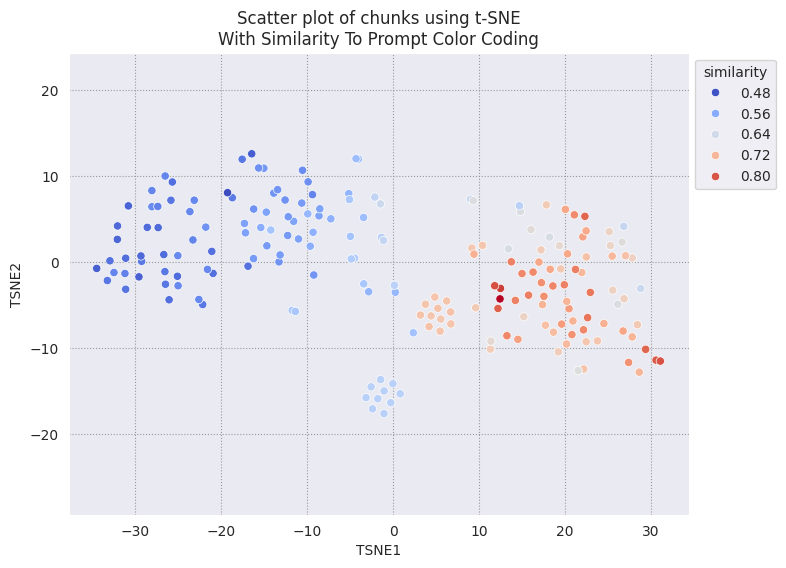

In [106]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

#### Visualizing Chunks - Call Out Matches

In [107]:
matches = chunk_match(question)

In [108]:
df_tsne.iloc[[match[0] for match in matches]]

,TSNE1,TSNE2,similarity
108,12.418231,-4.310772,0.838544
34,12.469169,-3.088318,0.814508
127,11.798691,-2.779829,0.803332
84,31.069904,-11.544809,0.802887


(-37.77910804748535, 34.34842872619629, -19.17257914543152, 14.081841802597046)

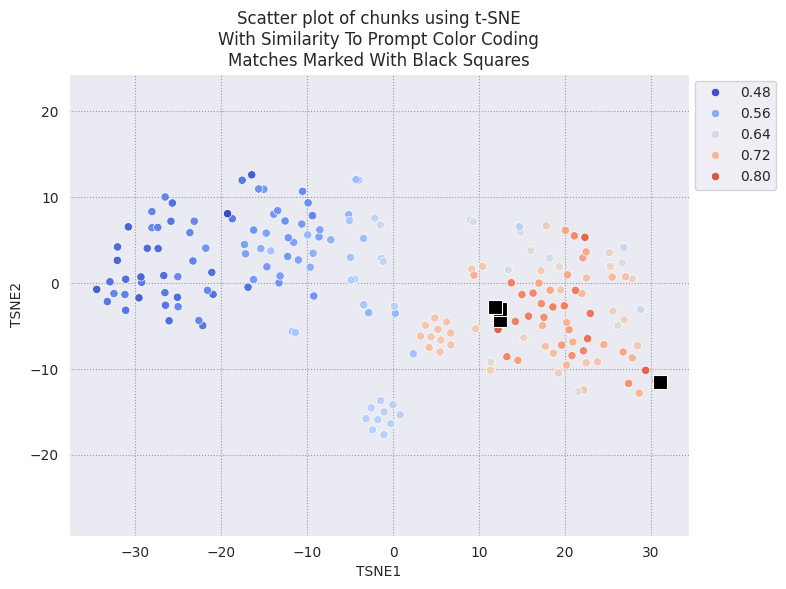

In [109]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.scatterplot(data = df_tsne.iloc[[match[0] for match in matches]], x="TSNE1", y="TSNE2", color = 'black', marker = 's', s = 100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding\nMatches Marked With Black Squares")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [110]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [111]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

In [112]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [113]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'table', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Q&A With MetadataBot

### Functions For Bot

#### Retrieval Functions

These retrieve context.

In [114]:
def get_chunks(query, k = -1, simk = -1):
    # k set the number of matches to retrieve, regarless of similarity. k = -1 will trigger calculating k dynamically.
    # simk sets a threshold for similarity: <=0 uses k, (0,1] will get all matches with similarity in range [1-simk, 1] 
    
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T) # for dot product, higher is better match, since normalized embeddings 1 is best, 0 is worst
    matches = np.argsort(similarity)[::-1].tolist()
    
    if k <= 0:
        # algorithm to dynamically pick k
        k = 1 + 3*int(10*(1-similarity[matches[0]]))
    if simk <= 0:
        matches = [(match, similarity[match]) for match in matches[0:k]]
    elif simk > 0 and simk <= 1:
        indicies = np.where(similarity >= 1-simk)[0]
        matches = [(i, similarity[i]) for i in indicies]
     
    return matches

def expand_retrieval(contexts, DISTANCE):
    
    additional_contexts = []
    if DISTANCE > 0:
        
        # for each page look for surrounding chunks, collect chunks
        chunk_indexes = []
        for context in contexts:
            # get matches for the page from contexts
            matches = get_retrieval(context[2], simk = DISTANCE, file_page = (context[3]['file_index'], context[3]['page_index']))
            for match in matches:
                if match[0] not in chunk_indexes and match[0] not in [c[0] for c in contexts]:
                    chunk_indexes += [match[0]]
                    additional_contexts.append(match)

    return additional_contexts

def get_retrieval(question, k = -1, simk = -1, DISTANCE = 0, file_page = None):

    if file_page: # this is from a call to this function by expand_retrieval
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], True) for match in get_chunks(question, k = k, simk = simk) if file_page == (files_pages_chunks[match[0]]['metadata']['file_index'], files_pages_chunks[match[0]]['metadata']['page_index'])]
    else: # this is from a call to this function by the main function: document_bot
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], False) for match in get_chunks(question, k = k, simk = simk)]
    
    if DISTANCE > 0:
        matches = matches + expand_retrieval(matches, DISTANCE)
    
    return matches

In [161]:
#submittal_str = "Includes technical data and drawings specially prepared for this Project, including fabrication and installation drawings, diagrams, actual performance curves, data sheets, schedules, templates, patterns, reports, instructions, design mix formulas, measurements, and similar information not in standard printed form."
#test_response = get_retrieval(submittal_str)

In [162]:
#test_response[0]

---
### Embeddings Search: AKA Vector Search

#### Get Embedding for Question

In [52]:
print(question)

How is baseball played?


In [53]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
query_embed.shape

(768,)

#### Create Local Embedding DB - With Numpy!

In [54]:
embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])
embed_db.shape

(1431, 768)

#### Get Matches - With Numpy!

#### Dot Product

- measures alignment between two vectors
- large positive implies similar directions
- large negative implies opposite directions
- near zero implies orthoganal
- larger is more similar
- best for:
    - matching and retrieval


In [55]:
similarity = np.dot(query_embed, embed_db.T)
similarity.shape

(1431,)

In [56]:
# larger is more similar
matches = np.argsort(similarity)[::-1][:5].tolist()
matches = [(match, similarity[match]) for match in matches]
matches

[(39, 0.7943348363193913),
 (1237, 0.7538162615089775),
 (64, 0.7412778232091074),
 (46, 0.7408337201716614),
 (194, 0.7400998881834598)]

In [57]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Layout of the Field
2.2
2.Home Base
2.3
3
The Bases
3
3
4
The Pitcher's Plate
2.4
2.Benches
4
3.
A PITCH is a ball delivered to the batter by the pitcher.
(
1.01 Baseball is a game between two teams of nine players each, under
direction of a manager, played on an enclosed field in accordance
with these rules, under jurisdiction of one or more umpires.
1.02 The offensive team's objective is to have its batter become a runner,
and its runners advance.
1
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot 

#### Cosine Similarity

- measures angle between two vectors
- represents the cosine of the angles resulting in values -1 to 1
- larger is more similar
- best for:
    - grouping for topics: different magnitudes can still group together
    - collaborative filtering for recommendation systems


In [58]:
cosine_similarity = similarity / (np.linalg.norm(query_embed) * np.linalg.norm(embed_db, axis = 1).T)
cosine_similarity.shape

(1431,)

In [59]:
# larger is more similar
matches = np.argsort(cosine_similarity)[::-1][:5].tolist()
matches = [(match, cosine_similarity[match]) for match in matches]
matches

[(39, 0.7943370848679859),
 (1237, 0.7538182038518724),
 (64, 0.7412802905681056),
 (46, 0.7408373053761771),
 (194, 0.740102083374133)]

In [60]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Layout of the Field
2.2
2.Home Base
2.3
3
The Bases
3
3
4
The Pitcher's Plate
2.4
2.Benches
4
3.
A PITCH is a ball delivered to the batter by the pitcher.
(
1.01 Baseball is a game between two teams of nine players each, under
direction of a manager, played on an enclosed field in accordance
with these rules, under jurisdiction of one or more umpires.
1.02 The offensive team's objective is to have its batter become a runner,
and its runners advance.
1
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot 

#### Euclidean Distance

- straight line distance between two vector points
- smaller is more similar
- note that smaller magnitude vectors with large angles may be deemed more similar than larger magnitude vectors with small angles
- best for:
    - clustering points in vector space
    - anomaly detection

In [61]:
euclidean_similarity = np.linalg.norm(embed_db - query_embed, axis = 1)
euclidean_similarity.shape

(1431,)

In [62]:
# smaller is more similar
matches = np.argsort(euclidean_similarity)[:5].tolist()
matches = [(match, euclidean_similarity[match]) for match in matches]
matches

[(39, 0.6413459798848368),
 (1237, 0.7016853451771369),
 (64, 0.7193314233105705),
 (46, 0.7199464430577136),
 (194, 0.7209676078048342)]

In [63]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Layout of the Field
2.2
2.Home Base
2.3
3
The Bases
3
3
4
The Pitcher's Plate
2.4
2.Benches
4
3.
A PITCH is a ball delivered to the batter by the pitcher.
(
1.01 Baseball is a game between two teams of nine players each, under
direction of a manager, played on an enclosed field in accordance
with these rules, under jurisdiction of one or more umpires.
1.02 The offensive team's objective is to have its batter become a runner,
and its runners advance.
1
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot 

#### Search Function: Pages

Using dot product, create an embedding database and accompanying search function.

In [64]:
pages_embed_db = np.array([page['parsing']['embedding'] if page['parsing']['embedding'] else [0]*768 for page in files_pages])

In [65]:
def page_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, pages_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [66]:
page_match(question)

[(7, 0.7302177884888287),
 (12, 0.7210220056833884),
 (29, 0.7193928313358192),
 (6, 0.7109443057004161),
 (8, 0.7076297629443389),
 (9, 0.7044805045750475),
 (2, 0.7026532650557955)]

#### Search Function: Chunks

Using dot product, create an embedding database and accompanying search function.

In [67]:
chunks_embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])

In [68]:
def chunk_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [69]:
chunk_match(question)

[(39, 0.7943348363193913),
 (1237, 0.7538162615089775),
 (64, 0.7412778232091074),
 (46, 0.7408337201716614),
 (194, 0.7400998881834598),
 (197, 0.7370953729405255),
 (649, 0.7364257654505798)]

---
### Visualize Relationships Between Chunks

The embeddings are incredibly high dimensional - 768!  To reduce this to a lower dimension, like 2 for plotting, the method [`t-SNE`](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) will be used.  This method models each embedding with a lower 2-dimensional point in a way that similar embeddings are modeled by nearby poiints and dissimilar embeddings by farther points.

#### Visualizing Chunks

In [70]:
tsne = TSNE(random_state=0, n_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(chunks_embed_db)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [71]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-55.78952350616455, 70.79153385162354, -39.45735874176025, 49.78066577911377)

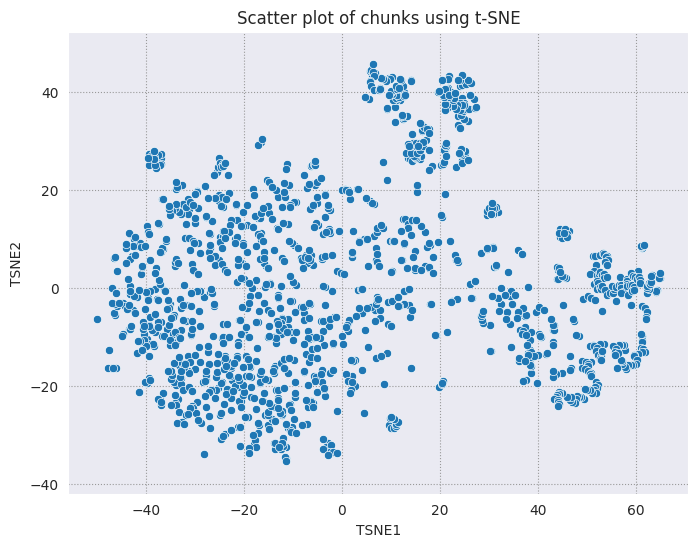

In [72]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2')
plt.title("Scatter plot of chunks using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

#### Visualizing Chunks - Color Codeded By Similarity To Prompt

In [73]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
similarity = np.dot(query_embed, chunks_embed_db.T)
df_tsne['similarity'] = similarity.tolist()

(-55.78952350616455, 70.79153385162354, -39.45735874176025, 49.78066577911377)

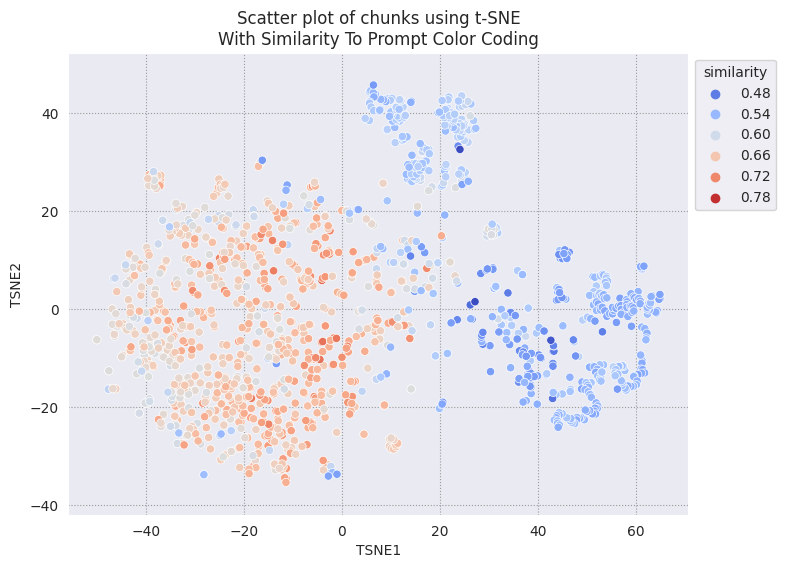

In [74]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

#### Visualizing Chunks - Call Out Matches

In [75]:
matches = chunk_match(question)

In [76]:
df_tsne.iloc[[match[0] for match in matches]]

,TSNE1,TSNE2,similarity
39,10.093793,-2.666891,0.794335
1237,-1.819205,-11.372604,0.753816
64,8.660136,-19.629980,0.741278
46,-4.031733,5.827052,0.740834
194,-7.268339,-27.710226,0.740100
197,-3.863959,-6.651836,0.737095
649,-4.442042,-10.306313,0.736426


In [115]:
def get_augmented(question, contexts, ground):
    prompt = ''
    
    if ground:
        prompt += "Give a detailed answer to the question using only the information from the numbered contexts provided below."
        prompt += "\n\nContexts:\n"
        prompt += "\n".join([f'  * Context {c+1}: "{context[2]}"' for c, context in enumerate(contexts)])
        prompt += "\n\nQuestion: " + question
    else:
        prompt += "Question: " + question
        
    # add the trigger to the prompt.  In this case, also include the zero shot chain of thought prompt "think step by step".
    prompt += "\n\nAnswer the question and give and explanation. Think step by step."
    
    return prompt

In [ ]:
def get_augmented(question, contexts, ground):
    prompt = ''
    
    if ground:
        prompt += "Give a detailed answer to the question using only the information from the numbered contexts provided below."
        prompt += "\n\nContexts:\n"
        prompt += "\n".join([f'  * Context {c+1}: "{context[2]}"' for c, context in enumerate(contexts)])
        prompt += "\n\nQuestion: " + question
    else:
        prompt += "Question: " + question
        
    # add the trigger to the prompt.  In this case, also include the zero shot chain of thought prompt "think step by step".
    prompt += "\n\nAnswer the question and give and explanation. Think step by step."
    
    return prompt

---
## Metadata Bot

#### Generation Functions

These functions interact with LLMs to create responses.

In [120]:
def generate_gemini(prompt, genconfigs, model):
    response = model.generate_content(
        prompt,
        generation_config = vertexai.generative_models.GenerationConfig(
            **genconfigs
            
        )
    )

    try:
        text = response.text
    except Exception:
        text = None

    counter = 0
    while not text:
        genconfigs['temperature'] = .5 - counter*.1
        response = model.generate_content(
            prompt,
            generation_config = vertexai.generative_models.GenerationConfig(
                **genconfigs

            )
        )
        try:
            text = response.text
        except Exception:
            text = None
            counter += 1

        if counter == 6:
            text = 'Please check the prompt, it appears the response is getting blocked.'
    
    return text

def generate_palm(prompt, genconfigs, model):
    response = model.predict(
        prompt,
        **genconfigs
    )
    
    return response.text

def get_generation(prompt, max_output_tokens, model):
    models = dict(GEMINI = gemini15_multimodal)
    
    genconfigs = dict(max_output_tokens = max_output_tokens)
    
    if model == 'GEMINI':
        response = generate_gemini(prompt, genconfigs, models[model])
    else:
        response = generate_palm(prompt, genconfigs, models[model])
    
    return response

#### Presentation Functions

These prepare the response for presentation - and display the results.

In [121]:
# get a font to use for annotating the page images:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

def get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations):
    # repeat the question
    IPython.display.display(IPython.display.Markdown(f'**The Question:**\n\n{question}\n\n'))
    
    if display_contexts:
    # display the contexts information: page, similarity, hyperlink
        context_pres = '**Sources:**\n\n'
        pages = []
        context_types = [c[4] for c in contexts]
        if DISTANCE > 0:
            context_pres += f'Note: The {len(contexts) - sum(context_types)} contexts were expanded to gather {sum(context_types)} additional chunks on pages with matches using a similarity distance of {DISTANCE}.\n'
        for context in contexts:
            page = next([d['parsing']['path'], d['parsing']['file'], d['parsing']['page'], d['file_index'], d['page_index']] for d in files_pages if d['file_index'] == context[3]['file_index'] and d['page_index'] == context[3]['page_index'])
            pages.append(page)
            if not context[4]:
                context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to question is {context[1]:.3f}\n'
            # the following is commented out, if uncommented it would also add the expanded contexts to printed list (this can be very long for DISTANCE = 1 which is the full page)
            #else:
            #    context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to primary context is {context[1]:.3f}\n'
        IPython.display.display(IPython.display.Markdown(context_pres))
        
    if display_annotations:
    # display each page with annotations
        IPython.display.display(IPython.display.Markdown('**Annotated Document Pages**\n\n'))
        # list of unique pages across contexts: sorted list of tuple(file_index, page_index)
        pages = sorted(list(set([(page[3], page[4]) for page in pages])), key = lambda x: (x[0], x[1]))
        # list of PIL images for each unique page
        images = []
        for page in pages:
            image = next(d['parsing']['pages'][0]['image']['content'] for d in files_pages if d['file_index'] == page[0] and d['page_index'] == page[1])
            images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            image.encode('utf-8')
                        )
                    )
                )
            )
        # annotate the contexts on the pages:
        for c, context in enumerate(contexts):
            image = images[pages.index((context[3]['file_index'], context[3]['page_index']))]
            vertices = context[3]['vertices']
            draw = PIL.ImageDraw.Draw(image)
            if not context[4]: 
                color = 'green'
                prefix = 'Source'
            else:
                color = 'blue'
                prefix = 'Expanded Source'
            draw.polygon([
                vertices[0]['x'], vertices[0]['y'],
                vertices[1]['x'], vertices[1]['y'],
                vertices[2]['x'], vertices[2]['y'],
                vertices[3]['x'], vertices[3]['y']
            ], outline = color, width = 5)
            draw.text(
                xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {c+1}", fill = color, anchor = 'rd', font = font
            )
        
        for image in images:
            IPython.display.display(image.resize(tuple([int(.25*x) for x in image.size])))
            
    return

In [122]:
def document_bot(question, max_output_tokens = 1000, DISTANCE = 0, MODEL = 'GEMINI', display_contexts = False, display_annotations = False, ground = True):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on unique pages
    # MODEL = 'GEMINI' # one of: GEMINI, PALM_BISON, PALM_BISON32K, PALM_UNICORN
    
    # R: Retrival
    if ground:
        contexts = get_retrieval(question, DISTANCE = DISTANCE)
    else:
        contexts = []
        
    # A: Augemented
    prompt = get_augmented(question, contexts, ground)
    
    # G: Generation
    response = get_generation(prompt, max_output_tokens, MODEL)
    
    # Present Answer
    get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations)
    
    return prompt

In [328]:
def metadata_bot(question, max_output_tokens = 1000, DISTANCE = 0, MODEL = 'GEMINI', display_contexts = False, display_annotations = False, ground = True):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on unique pages
    # MODEL = 'GEMINI' # one of: GEMINI, PALM_BISON, PALM_BISON32K, PALM_UNICORN
    
    # R: Retrival
    if ground:
        contexts = get_retrieval(question, DISTANCE = DISTANCE)
    else:
        contexts = []
        
    prompt = question
    
    if len(contexts) != 0:
        response = "Match found"
    else:
        response = "No match found"
        
    # A: Augemented
    #prompt = get_augmented(question, contexts, ground)
    
    # G: Generation
    #response = get_generation(prompt, max_output_tokens, MODEL)
    
    # Present Answer
    get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations)
    
    return prompt, contexts

### Add metadata for each submittal

In [ ]:
#prompt = metadata_bot(submittal_str, display_contexts = True, display_annotations = True)

In [334]:
#test_str = "Includes technical data and drawings specially prepared for this Project, including fabrication and installation drawings, diagrams, actual performance curves, data sheets, schedules, templates, patterns, reports, instructions, design mix formulas, measurements, and similar information not in standard printed form."
#prompt, contexts = metadata_bot(test_str, display_contexts = True, display_annotations = True)

In [341]:
submittal_df['validation_similarity_score'] = ''
submittal_df['validation_page_index'] = ''
submittal_df['validation_vertices'] = ''
#submittal_df

/var/tmp/ipykernel_13316/1106324448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submittal_df['validation_similarity_score'] = ''
/var/tmp/ipykernel_13316/1106324448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submittal_df['validation_page_index'] = ''
/var/tmp/ipykernel_13316/1106324448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [338]:
contexts[0]

(10,
 0.988200315916821,
 'Includes technical data and drawings specially prepared for this project,\nincluding fabrication and installation drawings, diagrams, actual\nperformance curves, data sheets, schedules, templates, patterns, reports,\ninstructions, design mix formulas, measurements, and similar information\nnot in standard printed form.\nD',
 {'file_index': 0,
  'page_index': 1,
  'paragraph': 31,
  'chunk': 11,
  'vme_id': '0_1_10',
  'vertices': [{'x': 513.9999966, 'y': 1760.00006},
   {'x': 1608.0000564000002, 'y': 1760.00006},
   {'x': 1608.0000564000002, 'y': 1950.9999599999999},
   {'x': 513.9999966, 'y': 1950.9999599999999}],
  'normalized_vertices': [{'x': 0.2923777, 'y': 0.7736264},
   {'x': 0.9146758, 'y': 0.7736264},
   {'x': 0.9146758, 'y': 0.8575824},
   {'x': 0.2923777, 'y': 0.8575824}]},
 False)

**The Question:**

Includes technical data and drawings specially prepared for this Project, including fabrication and installation drawings, diagrams, actual performance curves, data sheets, schedules, templates, patterns, reports, instructions, design mix formulas, measurements, and similar information not in standard printed form.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=1
	* page: 1, similarity to question is 0.988


**Annotated Document Pages**



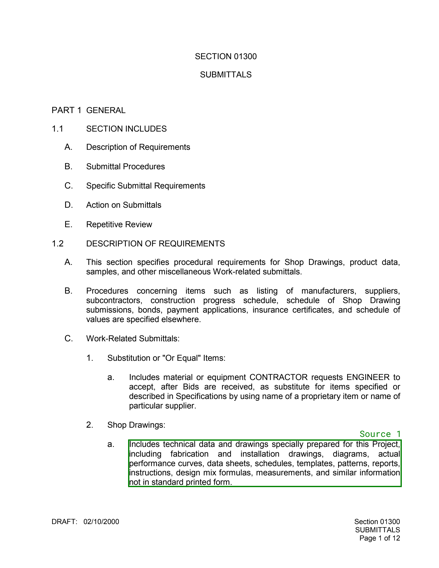

**The Question:**

Includes standard printed information on manufactured products, and systems that has not been specially prepared for this Project, including manufacturer's product specifications and installation instructions, catalog cuts, standard wiring diagrams, printed performance curves, mill reports, and standard color charts.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=2
	* page: 2, similarity to question is 0.994


**Annotated Document Pages**



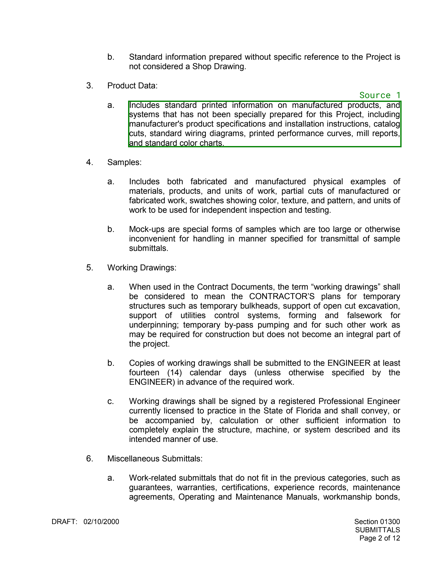

**The Question:**

Includes both fabricated and manufactured physical examples of materials, products, and units of work, partial cuts of manufactured or fabricated work, swatches showing color, texture, and pattern, and units of work to be used for independent inspection and testing.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=2
	* page: 2, similarity to question is 0.989


**Annotated Document Pages**



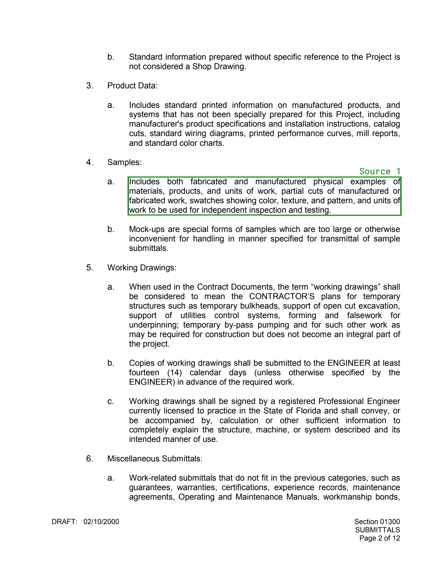

**The Question:**

Copies of working drawings shall be submitted to the ENGINEER at least fourteen (14) calendar days (unless otherwise specified by the ENGINEER) in advance of the required work.
Working drawings shall be signed by a registered Professional Engineer currently licensed to practice in the State of Florida and shall convey, or be accompanied by, calculation or other sufficient information to completely explain the structure, machine, or system described and its intended manner of use.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=2
	* page: 2, similarity to question is 0.930


**Annotated Document Pages**



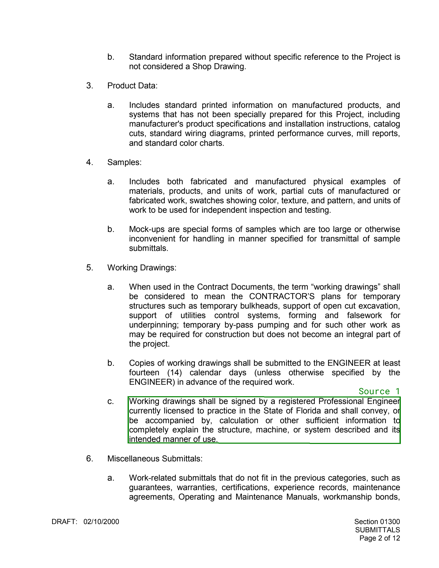

**The Question:**

Work-related submittals that do not fit in the previous categories, such as guarantees, warranties, certifications, experience records, maintenance agreements, Operating and Maintenance Manuals, workmanship bonds, survey data and reports, physical work records, quality testing and certifying reports, copies of industry standards, record drawings, field measurement data, and similar information, devices, and materials applicable to the Work.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=2
	* page: 2, similarity to question is 0.944


**Annotated Document Pages**



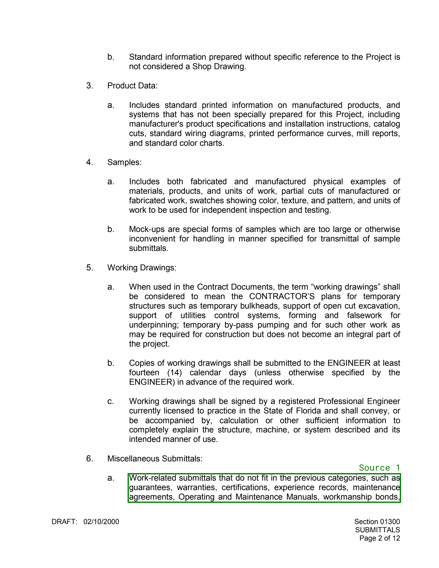

**The Question:**

Includes material or equipment CONTRACTOR requests ENGINEER to accept, after Bids are received, as substitute for items specified or described in Specifications by using name of a proprietary item or name of particular supplier.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=1
	* page: 1, similarity to question is 0.997


**Annotated Document Pages**



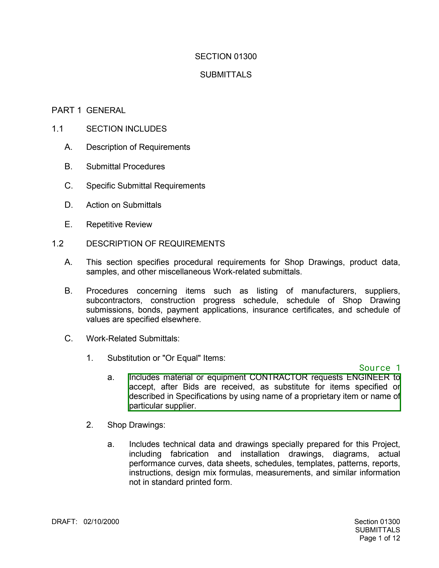

**The Question:**

Prepare and transmit each submittal to ENGINEER sufficiently in advance of scheduled performance of related work and other applicable activities.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=10
	* page: 10, similarity to question is 0.883
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=10
	* page: 10, similarity to question is 0.871
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=4
	* page: 4, similarity to question is 0.870
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=10
	* page: 10, similarity to question is 0.868


**Annotated Document Pages**



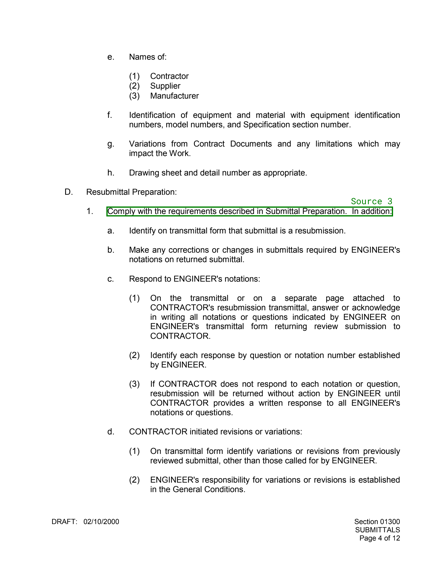

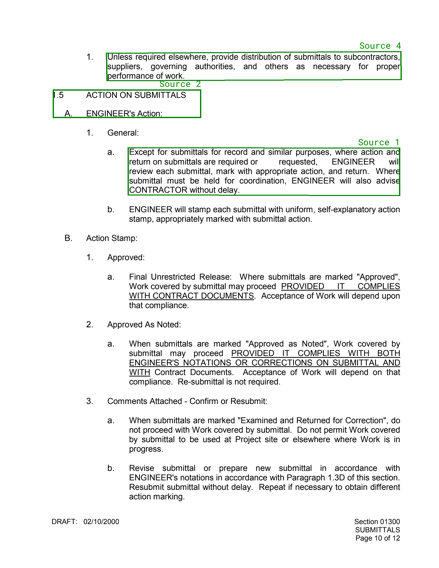

**The Question:**

Submit Operation and Maintenance Manuals in accordance with Section 01730.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=9
	* page: 9, similarity to question is 0.994


**Annotated Document Pages**



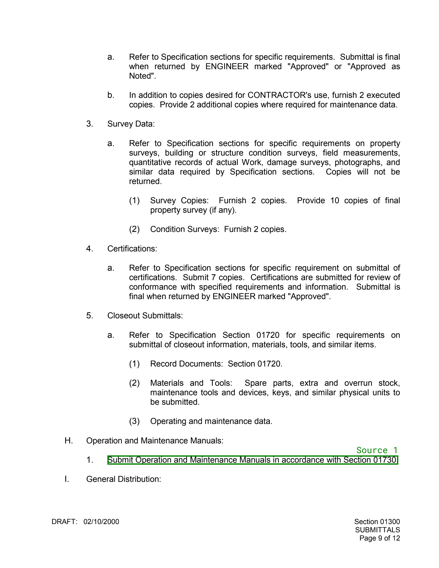

**The Question:**

Refer to Specification Section 01720 for specific requirements on submittal of closeout information, materials, tools, and similar items.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=9
	* page: 9, similarity to question is 0.850
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=9
	* page: 9, similarity to question is 0.823
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=9
	* page: 9, similarity to question is 0.818
1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=4
	* page: 4, similarity to question is 0.805


**Annotated Document Pages**



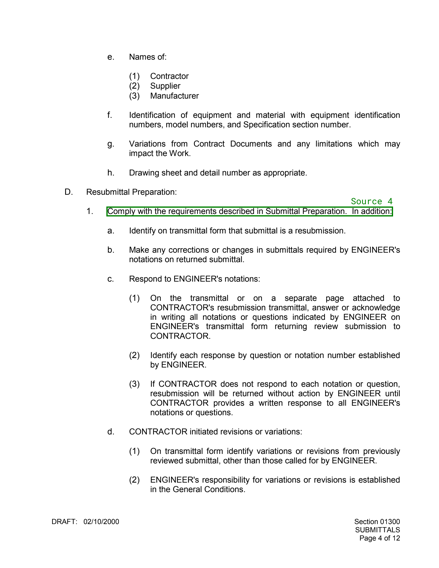

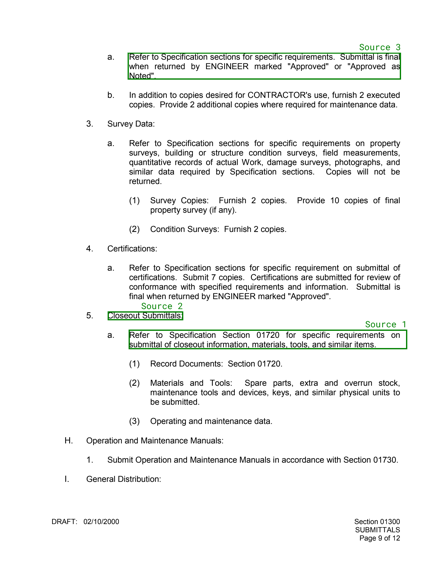

**The Question:**

submitted for each item will be reviewed no more than twice at the OWNER's expense. All subsequent reviews will be performed at times convenient to the ENGINEER and at the CONTRACTOR's expense based on the ENGINEER's then prevailing rates including all direct and indirect costs and fees. Reimburse the OWNER for all such fees invoiced to the OWNER by the ENGINEER.




**The Response:**

Match found



**Sources:**

1. gs://mg-ce-demos/doc-gen-demo/samples/L-01300 - SUBMITTALS.pdf#page=11
	* page: 11, similarity to question is 0.911


**Annotated Document Pages**



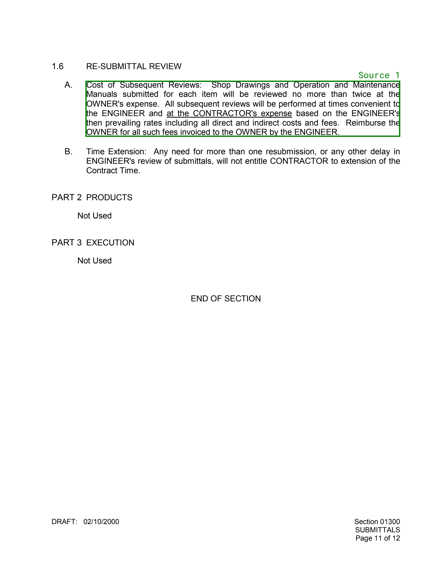

In [342]:
for index, row in submittal_df.iterrows():
    submittal_str = row['submittal']
    prompt, contexts = metadata_bot(submittal_str, display_contexts = True, display_annotations = True)
    
    submittal_df.at[index, 'validation_similarity_score'] = contexts[0][1]
    submittal_df.at[index, 'validation_page_index'] = contexts[0][3]['page_index']
    submittal_df.at[index, 'validation_vertices'] = contexts[0][3]['vertices']
    

### Final DF

In [343]:
submittal_df

,name,description,other_information,page,submittal,validation_similarity_score,validation_page_index,validation_vertices
0,Shop Drawings,Includes technical data and drawings specially...,Standard information prepared without specific...,"1, 2",Includes technical data and drawings specially...,0.9882,1,"[{'x': 513.9999966, 'y': 1760.00006}, {'x': 16..."
1,Product Data,Includes standard printed information on manuf...,None,2,Includes standard printed information on manuf...,0.993883,2,"[{'x': 513.9999966, 'y': 403.00000650000004}, ..."
2,Samples,Includes both fabricated and manufactured phys...,Mock-ups are special forms of samples which ar...,2,Includes both fabricated and manufactured phys...,0.988952,2,"[{'x': 511.00002234, 'y': 706.000022}, {'x': 1..."
3,Working Drawings,"When used in the Contract Documents, the term ...",Copies of working drawings shall be submitted ...,2,Copies of working drawings shall be submitted ...,0.929733,2,"[{'x': 511.99999031999994, 'y': 1586.99996}, {..."
4,Miscellaneous Submittals,Work-related submittals that do not fit in the...,None,"2, 3",Work-related submittals that do not fit in the...,0.943976,2,"[{'x': 511.00002234, 'y': 1895.000016}, {'x': ..."
5,"Substitution or ""Or Equal""",Includes material or equipment CONTRACTOR requ...,None,"1, 5",Includes material or equipment CONTRACTOR requ...,0.996674,1,"[{'x': 512.99999346, 'y': 1495.0000975}, {'x':..."
7,each submittal,None,Prepare and transmit each submittal to ENGINEE...,3,Prepare and transmit each submittal to ENGINEE...,0.882995,10,"[{'x': 511.99999031999994, 'y': 589.0000024999..."
8,Operation and Maintenance Manuals,None,Submit Operation and Maintenance Manuals in ac...,9,Submit Operation and Maintenance Manuals in ac...,0.994291,9,"[{'x': 430.00001412, 'y': 1824.999995}, {'x': ..."
9,Closeout submittals,"closeout information, materials, tools, and si...",Refer to Specification Section 01720 for speci...,9,Refer to Specification Section 01720 for speci...,0.850109,9,"[{'x': 515.9999853, 'y': 1320.99997575}, {'x':..."
10,Shop Drawings and Operation and Maintenance Ma...,None,submitted for each item will be reviewed no mo...,11,submitted for each item will be reviewed no mo...,0.911225,11,"[{'x': 342.99998705999997, 'y': 323.0000182500..."


### Controlled Generation = Structured Output

In [7]:
response_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
        "properties": {
            "scope": {"type": "STRING"},
            "terms and conditions": {"type": "INTEGER"},
            "specifications": {"type": "STRING"},
            "pricing": {"type": "STRING"},
        },
        "required": ["scope", "contract and terms", "specifications", "pricing"],
    },
}



In [8]:
prompt = """
    Generate a sales contract for a new sale of coal, between a supplier and buyer, include terms and conditions, specifications, and pricing for the sale.  
    This is a legal document, the language included in the contract draft should leverage appropriate legal language.
    
    Utilize the following information for specifics regarding the sale:
    - 
"""


In [12]:
response = gemini15_multimodal.generate_content(
    prompt,
    generation_config=GenerationConfig(
        response_mime_type="application/json", response_schema=response_schema
    ),
)

print(response.text)

[{"age": 42, "children": [{"age": 10, "name": "Alice"}, {"age": 7, "name": "Bob"}, {"age": 5, "name": "Charlie"}], "name": "Anya Petrova", "occupation": "Warden", "background": "Anya is a stern but fair warden of the city's prison.  Widowed at a young age, she raised her three children while maintaining order in a chaotic environment. Her experiences have shaped her into a formidable leader, respected by both prisoners and guards.", "playable": true}] 


In [13]:
IPython.display.Markdown(response.text)

[{"age": 42, "children": [{"age": 10, "name": "Alice"}, {"age": 7, "name": "Bob"}, {"age": 5, "name": "Charlie"}], "name": "Anya Petrova", "occupation": "Warden", "background": "Anya is a stern but fair warden of the city's prison.  Widowed at a young age, she raised her three children while maintaining order in a chaotic environment. Her experiences have shaped her into a formidable leader, respected by both prisoners and guards.", "playable": true}] 